In [ ]:
import tensorflow
import tensorflow.keras
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import cv2
import urllib
import numpy as np
# sample execution (requires torchvision)
from PIL import Image
# from torchvision import transforms
from tensorflow.keras.models import Model, load_model

In [ ]:
import shutil
import time

In [ ]:
#### 데이터 준비

In [4]:
cap = cv2.VideoCapture(1, cv2.CAP_DSHOW)
is_opened = cap.isOpened()

if cap.isOpened():
    ret, frame = cap.read()
    if ret:
#         frame = frame[100:1400, :]
        cv2.imshow('camera', frame)
    print('Video source detected')
    print('width: {}, height : {}'.format(cap.get(3), cap.get(4)))
else:
    print('NO video source detected. shutdown')
    exit()

Video source detected
width: 640.0, height : 480.0


In [5]:
record_duration = 4
print('')
print('')
print('')
print('')

print('First we should know how your muscle look like')
print('We will record your muscle for {} seconds each'.format(str(record_duration)))
print('')
print('')

input('Press Any key to start recording your palm')
diff = record_duration -1 
t_end = time.time() + record_duration
rest = []
while t_end > time.time():
    delta = t_end - time.time()
    if int(delta) != diff:
        diff = int(delta)
        print("{} seconds remain".format(str(diff + 1)))
    ret, fram = cap.read()
    if ret:
        fram = cv2.cvtColor(fram, cv2.COLOR_BGR2GRAY)
#         fram = fram[100:1400, :]
        #cv2.imshow('cam 0', fram)
        rest.append(cv2.resize(fram, (128,128)))
    else:
        print("Lost video source. Shutdown")
        exit()

input('Press Any key to start recording your fist')
diff = record_duration - 1
t_end = time.time() + record_duration
thumb = []
while t_end > time.time():
    delta = t_end - time.time()
    if int(delta) != diff:
        diff = int(delta)
        print("{} seconds remain".format(str(diff)))
    ret, fram = cap.read()
    if ret:
        fram = cv2.cvtColor(fram, cv2.COLOR_BGR2GRAY)
#         fram = fram[100:1400, :]
        #cv2.imshow('cam 0', fram)
        thumb.append(cv2.resize(fram, (128, 128)))
    else:
        print("Lost video source. Shutdown")
        exit()





First we should know how your muscle look like
We will record your muscle for 4 seconds each




Press Any key to start recording your palm 


5 seconds remain
4 seconds remain
3 seconds remain
2 seconds remain
1 seconds remain


Press Any key to start recording your fist 


2 seconds remain
1 seconds remain
0 seconds remain


In [6]:
# print('훈련용 엄지 이미지 개수:', len(thumb))
# print('훈련용 검지 이미지 개수:', len(pnt))
# print('훈련용 중지 이미지 개수:', len(mid))
# print('훈련용 약지 이미지 개수:', len(ring))
print('훈련용 새끼 이미지 개수:', len(grab))
print('훈련용 하이 이미지 개수:', len(rest))

훈련용 새끼 이미지 개수: 122
훈련용 하이 이미지 개수: 122


In [7]:
x_data = rest + grab
y_data = [0 for i in range(len(rest))] + [1 for i in range(len(grab))]

In [8]:
train = {'img': [], 'label': []}
for i in x_data:
    train['img'].append(i)
for j in y_data:
    train['label'].append(j)
print(len(train['img']), len(train['label']))

244 244


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 모든 이미지를 1/255로 스케일을 조정합니다
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen(
        x_data,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

TypeError: 'ImageDataGenerator' object is not callable

In [ ]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

In [ ]:
#### 기본 중 기본 간단 CNN 모델

In [1]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
# model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 1)))
# model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       2

In [10]:
for i in range(len(train['img'])):
    train['img'][i] = np.expand_dims(train['img'][i], axis=2)
#     train['img'][i].reshape(256, 256, 3)

print(train['img'][0].shape)

(128, 128, 1)


In [13]:
from tensorflow.keras import optimizers

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
x_data[0].shape

(128, 128)

In [14]:
history = model.fit(np.array(train['img']), np.array(train['label']), epochs=10)

Epoch 1/10
8/8 [==============================] - 1s 82ms/step - loss: 0.1065 - accuracy: 0.9616
Epoch 2/10
8/8 [==============================] - 1s 81ms/step - loss: 0.0310 - accuracy: 0.9926
Epoch 3/10
8/8 [==============================] - 1s 82ms/step - loss: 0.0145 - accuracy: 1.0000
Epoch 4/10
8/8 [==============================] - 1s 81ms/step - loss: 0.0114 - accuracy: 0.9945
Epoch 5/10
8/8 [==============================] - 1s 82ms/step - loss: 0.0277 - accuracy: 0.9973
Epoch 6/10
8/8 [==============================] - 1s 82ms/step - loss: 0.0061 - accuracy: 0.9986
Epoch 7/10
8/8 [==============================] - 1s 82ms/step - loss: 0.0155 - accuracy: 0.9936
Epoch 8/10
8/8 [==============================] - 1s 82ms/step - loss: 7.3371e-04 - accuracy: 1.0000
Epoch 9/10
8/8 [==============================] - 1s 82ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 10/10
8/8 [==============================] - 1s 82ms/step - loss: 5.9762e-04 - accuracy: 1.0000


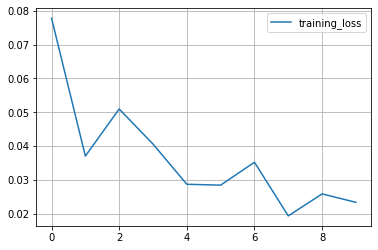

In [84]:
plt.plot(history.history['loss'], label = 'training_loss')
plt.legend()
plt.grid(True)

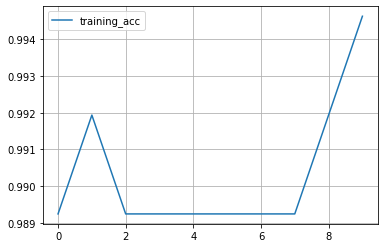

In [82]:
plt.plot(history.history['accuracy'], label = 'training_acc')
plt.legend()
plt.grid(True)

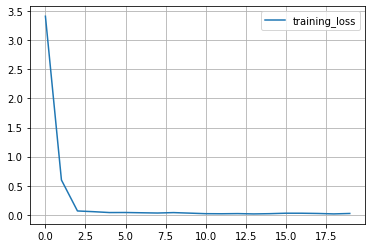

In [13]:
plt.plot(history.history['loss'], label = 'training_loss')
plt.legend()
plt.grid(True)

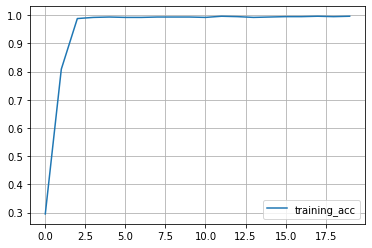

In [14]:
plt.plot(history.history['accuracy'], label = 'training_acc')
plt.legend()
plt.grid(True)

In [15]:
# 모델 저장
model.save('grab_classification.h5')

In [3]:
model = load_model('classification.h5')

In [5]:
cap = cv2.VideoCapture(1)

if cap.isOpened():                      # 캡쳐 객체 연결 확인
    while cv2.waitKey(33) != ord('q'):
        ret, fram = cap.read()
        if ret:
            fram = cv2.cvtColor(fram, cv2.COLOR_BGR2GRAY)
            original = fram
            img = cv2.resize(fram, (128,128))

            img_list = {'img': []}
            img_list['img'].append(img)
            img_list['img'] = np.expand_dims(img_list['img'], axis=3)
            prediction = model.predict(np.array(img_list['img']))
#             preds_classes = model.predict_classes(np.array(img_list['img']))
            preds_classes = np.argmax(prediction, axis=-1)

#             _, output_index = torch.max(output,0)
            if (preds_classes == 0):
                output_str = "rest : 0"
            if (preds_classes == 1):
                output_str = "grab : 1"

            cv2.putText(original, output_str, (250, 450), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2)
            cv2.imshow('output', original)

#             cv2.putText(original, output_str, 
#                 bottomLeftCornerOfText, 
#                 font, 
#                 fontScale,
#                 fontColor)
            if cv2.waitKey(10) == ord('q'):
                break
            
        else:
            break
cv2.destroyAllWindows()